## Big Data Project Timeseries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [160]:
#Add indicies for day of week, week of the year, and year
pjme = pd.read_csv("timeseries.csv") 
pjme.head()

,Date,Week_of_Year,Day_of_Week,Month_of_Year,Year_index,Avg_Temp_Across_Stations,Divvy_Total_Trips,Taxi_Total_Trips,L_CTA_Sum_rides,Community_Area_Number,Community_Name,ID
0,1/1/2014,1,4,1,2014,20.240967,NaN,438.0,246710.0,1,ROGERS PARK,1
1,1/1/2014,1,4,1,2014,20.240967,NaN,255.0,246710.0,2,WEST RIDGE,2
2,1/1/2014,1,4,1,2014,20.240967,5.0,1663.0,246710.0,3,UPTOWN,3
3,1/1/2014,1,4,1,2014,20.240967,NaN,582.0,246710.0,4,LINCOLN SQUARE,4
4,1/1/2014,1,4,1,2014,20.240967,NaN,777.0,246710.0,5,NORTH CENTER,5


In [161]:
#Fill Non Existent Values with 0 
pjme=pjme.fillna(0)
pjme.head()

,Date,Week_of_Year,Day_of_Week,Month_of_Year,Year_index,Avg_Temp_Across_Stations,Divvy_Total_Trips,Taxi_Total_Trips,L_CTA_Sum_rides,Community_Area_Number,Community_Name,ID
0,1/1/2014,1,4,1,2014,20.240967,0.0,438.0,246710.0,1,ROGERS PARK,1
1,1/1/2014,1,4,1,2014,20.240967,0.0,255.0,246710.0,2,WEST RIDGE,2
2,1/1/2014,1,4,1,2014,20.240967,5.0,1663.0,246710.0,3,UPTOWN,3
3,1/1/2014,1,4,1,2014,20.240967,0.0,582.0,246710.0,4,LINCOLN SQUARE,4
4,1/1/2014,1,4,1,2014,20.240967,0.0,777.0,246710.0,5,NORTH CENTER,5


In [163]:
TimeSeriesDat = pjme[['Taxi_Total_Trips','Month_of_Year','Week_of_Year', 'Day_of_Week', 'Year_index', 'Avg_Temp_Across_Stations','Divvy_Total_Trips','L_CTA_Sum_rides','Community_Area_Number']]
TimeSeriesDat.head()

,Taxi_Total_Trips,Month_of_Year,Week_of_Year,Day_of_Week,Year_index,Avg_Temp_Across_Stations,Divvy_Total_Trips,L_CTA_Sum_rides,Community_Area_Number
0,438.0,1,1,4,2014,20.240967,0.0,246710.0,1
1,255.0,1,1,4,2014,20.240967,0.0,246710.0,2
2,1663.0,1,1,4,2014,20.240967,5.0,246710.0,3
3,582.0,1,1,4,2014,20.240967,0.0,246710.0,4
4,777.0,1,1,4,2014,20.240967,0.0,246710.0,5


## Make Train-Test Split

In [164]:
#Make Test Set/Holdout Set of 2017
Test = TimeSeriesDat.loc[TimeSeriesDat['Year_index'] == 2017]

In [165]:
#Make Train Set of 2014-2016
Train = TimeSeriesDat.loc[TimeSeriesDat['Year_index'] < 2017]

In [166]:
train_X = Train.drop("Taxi_Total_Trips", axis=1)
train_Y = Train["Taxi_Total_Trips"]

test_X = Test.drop("Taxi_Total_Trips", axis=1)
test_Y = Test["Taxi_Total_Trips"]


## Apply XgBoost

In [167]:
reg = xgb.XGBRegressor(n_estimators=350, max_depth=9,silent=True, 
)
reg.fit(train_X, train_Y,
       verbose=True) # Change verbose to True if you want to see it train

C:\Users\omar\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\omar\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=9,
       min_child_weight=1, missing=None, n_estimators=350, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

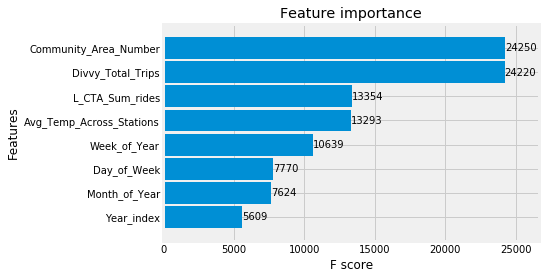

In [168]:
 _ = plot_importance(reg, height=0.9)

# Forecast Test Set

In [173]:
Taxi_Pred = pd.DataFrame(reg.predict(test_X ))
Taxi_Pred[Taxi_Pred < 0] = 0
Taxi_Pred.head(10)

,0
0,525.498474
1,1296.186035
2,1110.812866
3,602.391907
4,516.911499
5,4218.929199
6,4920.328613
7,2658.687012
8,2872.775391
9,10412.564453


In [174]:
from sklearn.metrics import mean_squared_error
from math import sqrt
MSE  = mean_squared_error(Taxi_Pred, test_Y)  #Calculate Mean Squared Error
RMSE = sqrt(MSE)
print ("RMSE : ", RMSE)

RMSE :  2729.8486089654884


In [175]:
Taxi_Pred.to_csv("pred.csv", index=False)
Test.to_csv("test.csv", index=False)